In [1]:
from lspi.basis_functions import ExactBasis, RadialBasisFunction
from lspi.policy import Policy
from lspi.policy_ct import QuadraticPolicy
from lspi.sample import Sample
from lspi.solvers import LSTDQSolver
import lspi
from lspi import domains
import os
import numpy as np

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# print file name in dir plot:
# for f in os.listdir('./plot'):
comb = []
for f in os.listdir('/Users/xinyi/Documents/Data/ossur/DC_04_07/'):
    if f.endswith('.csv'):
        # print(f)
        comb.append([float(s) for s in f.split('.')[0].split('_')])
comb = np.array(comb)

comb


array([[  0.,  40., 100.],
       [ 75.,  66.,  50.],
       [  0.,  48.,  75.],
       [ 75.,  48.,  25.],
       [ 50.,  75.,  50.],
       [ 50.,  66.,   0.],
       [ 25.,  48.,  25.],
       [  0.,  40.,   0.],
       [ 50.,  40.,   0.],
       [100.,  40.,  50.],
       [ 50.,  40., 100.],
       [  0.,  40.,  75.],
       [ 75.,  66.,   0.],
       [100.,  75.,   0.],
       [100.,  48.,   0.],
       [ 75.,  66., 100.],
       [  0.,  57., 100.],
       [ 50.,  48.,  25.],
       [  0.,  66.,  50.],
       [ 75.,  75., 100.],
       [ 25.,  66.,  75.],
       [ 50.,  57.,   0.],
       [ 25.,  75.,  25.],
       [ 25.,  75., 100.],
       [ 50.,  48.,   0.],
       [ 50.,  75.,   0.],
       [ 50.,  57., 100.]])

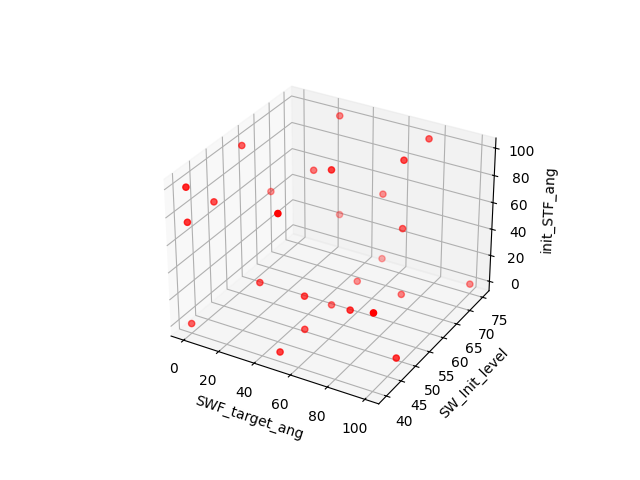

In [6]:
# %pip install ipympl
%matplotlib widget
import matplotlib.pyplot as plt

# visualize comb in an interactive 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(comb[:, 0], comb[:, 1], comb[:, 2], c='r', marker='o')

ax.set_xlabel("SWF_target_ang")
ax.set_ylabel("SW_Init_level")
ax.set_zlabel("init_STF_ang")  # Ensure z-label is displayed

plt.show()

In [2]:
ssar = np.load("ssar.npy")
ssar.shape
n_action = 3
n_state = 2

ws = np.load("policy_weights.npy")
policy = QuadraticPolicy(n_action=  n_action, n_state=n_state, weights=ws, discount=0.8, explore=0.01)
print(policy.num_actions,"*"*30)


Number of basis functions: 15
None ******************************


In [ ]:
state = np.array([0.5, 0.5])
ba = policy.best_action(state)

# policy.calc_q_value(np.array([0.001, 0.002]), 0)

array([-1.,  1., -1.])

In [13]:
from scipy.optimize import minimize
Huu, Hf = policy.extract_qp_parameters(state) 
print(Huu)
print(Hf)
action = ba
- 0.5 * action[None,:] @ Huu @ action[:,None] - Hf @ action[:,None]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

In [5]:

# Solve constrained optimization
res = minimize(
    fun=lambda a: 0.5 * a[None,:] @ Huu @ a[:,None] + Hf @ a[:,None], 
    x0=np.zeros((policy.n_action,)),
    bounds=[(-.5, .5)], # for a N(0,1) distribution, it is reasonable to set the bounds to (-3, 3), because 99.7% of the values will fall within this range
    # method = 'Nelder-Mead',
    # method = 'L-BFGS-B',
    # method = 'TNC',
    method = 'trust-constr',
    # constraints={'type': 'ineq', 'fun': lambda a: A @ a - Ax}
)
res.x

array([-0.4992152 ,  0.49934247, -0.49918231])

In [6]:
# policy.basis.evaluate(np.array([0.005, 0.002]), np.array([0,0,0]))
policy.calc_q_value(np.array([0.5, 0.5]), np.array([-1,1,1]))

array([[2.50875536]])

In [7]:
for i in (1, -1):
    for j in (1, -1):
        for k in (1, -1):
            print(policy.calc_q_value(np.array([0.5, 0.5]), np.array([i, j, k])))
    

[[2.35859439]]
[[2.41091824]]
[[2.19498491]]
[[1.53708606]]
[[2.50875536]]
[[3.22187726]]
[[2.56135754]]
[[2.56425675]]


In [26]:
np.unique(ssar[:,:],axis = 0).shape
23*23
# ssar.shape
# ssar[:,4].std()

529